## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Assignment 1, Task 1 - Basic ML Classifiers

In this task, you are going to implement two classifers and apply them to the  CIFAR-10 dataset: 

(1) Logistic regression classifier, and

(2) Softmax classifier.

In [1]:
# Import modules, make sure you have installed all required packages before you start.
import tensorflow as tf
import os
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load CIFAR-10 data

CIFAR-10 is a widely used dataset which contains 60,000 color images of size 32x32 divided into 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. We are going to use them to create our training set, validation set and test set.

See https://www.cs.toronto.edu/~kriz/cifar.html. 

### 10-class dataset
First, we load the raw CIFAR-10 data and create a 10-class dataset.

In [2]:
# Load the raw CIFAR-10 data. You can learn how to use CIFAR dataset by studing cifar_utils code,
# but you don't need to worry about that when doing this task.
X_train, y_train, X_test, y_test = load_data()

# We have vectorized the data (rearranged the storage of images) for you. 
# That is, we flattened 1×32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 color channels.
# The reason we do this is because we can not put 3-D image representations into our model. 
# This is common practice (flattening images before putting them into the ML model). 
# Note that this practice may not be used for Convolutional Neural Networks (CNN). 
# We will later see how we manage the data when used in CNNs in later assignments.

# Check the results
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Training labels shape:  (50000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)


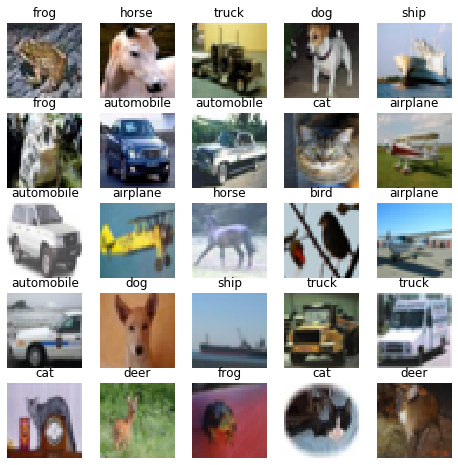

In [3]:
# This part will walk you through how to visualize the CIFAR-10 training dataset.
# We first find names of 10 categories.
f = open('data/cifar-10-batches-py/batches.meta', 'rb')
namedict = pickle.load(f, encoding='latin1')
f.close()
category = namedict['label_names']
# We then reshape vectorized data into the image format
X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

print(category)
print(X.shape)

#Visualizing CIFAR 10 data. We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        axes1[j][k].set_title(category[y_train[i]])

In [4]:
# Data organization:
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
#    Development data (for gradient check): 100 random samples from the train set: indices 1~49,000
#    Development data (binary) (only for gradient check in Part 1): 100 random samples from the subsampled binary train set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 100
num_dev_binary = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
Development data shape: (100, 3072)
Development data shape (100,)


### 2-class dataset
Next, in order to implement the experiment with the logistic regression classifier, we subsample the 10-class dataset to the 2-class dataset. 

In [5]:
# Subsample 10-class training set to 2-class training set
X_train_binary = X_train[y_train<2,:]
num_training_binary = X_train_binary.shape[0]
y_train_binary = y_train[y_train<2]
mask_binary = np.random.choice(num_training_binary, num_dev_binary, replace=False)

X_val_binary = X_val[y_val<2,:]
y_val_binary = y_val[y_val<2]

X_dev_binary = X_train_binary[mask_binary]
y_dev_binary = y_train_binary[mask_binary]


print('Train data (binary) shape: ', X_train_binary.shape)
print('Train labels (binary) shape: ', y_train_binary.shape)
print('Validation data (binary) shape: ', X_val_binary.shape)
print('Validation labels (binary) shape: ', y_val_binary.shape)
print('Development data (binary) shape:', X_dev_binary.shape)
print('Development data (binary) shape', y_dev_binary.shape)

Train data (binary) shape:  (9794, 3072)
Train labels (binary) shape:  (9794,)
Validation data (binary) shape:  (206, 3072)
Validation labels (binary) shape:  (206,)
Development data (binary) shape: (100, 3072)
Development data (binary) shape (100,)


In [6]:
# Preprocessing: subtract the mean value across every dimension, for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image


# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (100, 3073)


In [7]:
# Preprocessing: subtract the mean value across every dimension, for binary training data
mean_image = np.mean(X_train_binary, axis=0)

X_train_binary = X_train_binary.astype(np.float32) - mean_image.astype(np.float32)
X_val_binary = X_val_binary.astype(np.float32) - mean_image
X_dev_binary = X_dev_binary.astype(np.float32) - mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train_binary = np.hstack([X_train_binary, np.ones((X_train_binary.shape[0], 1))])
X_val_binary = np.hstack([X_val_binary, np.ones((X_val_binary.shape[0], 1))])
X_dev_binary = np.hstack([X_dev_binary, np.ones((X_dev_binary.shape[0], 1))])
print(X_train_binary.shape, X_val_binary.shape, X_dev_binary.shape)

(9794, 3073) (206, 3073) (100, 3073)


## Part 1: Logistic Regression Classifier

In this part, you are going to implement a logistic regression classifier. 

Let’s assume a training dataset of images $x_i \in R^D$, each associated with a label $y_i$. Here $i=1 \dots N$ and $y_i \in 1 \dots K$. That is, we have **N** examples (each with a dimensionality **D**) and **K** distinct categories.

We will now define the score function $f: R^D \to R^K$ that maps the raw image pixels to class scores: $$f(x_i; W, b)=W x_i + b$$
where $W$ is of size $K \times D$ and $b$ is of size $K \times 1$. 

Here we will use **bias trick** to represent the two parameters $W,b$ as one by extending the vector $x_i$ with one additional dimension that always holds the constant **1** - a default bias dimension. With the extra dimension, the new score function will simplify to a single matrix multiply: $$f = f(x_i;W)=W x_i$$

**Brief introduction to logistic regression classifier**

Logistic regression classifier can solve a binary classification problem ($K=2$). A binary logistic regression classifier has only two classes (0,1), and calculates the probability of class 1 as:

$$
P(y=1 | x ; w)=\frac{1}{1+e^{-f}}=\sigma\left(f\right)
$$

Since the probabilities of class 1 and 0 sum to one, the probability for class 0 is:

$$
P(y=0 | x ; w)=1-P(y=1 | x ; w)
$$

Hence, an example is classified as a positive example ($y = 1$) if $\sigma\left(f\right)>0.5$, or equivalently if the score $f>0$. The loss function then maximizes the log likelihood of this probability. You can convince yourself that this simplifies to:

$$
L_{i}=\sum_{j} y_{i j} \log \left(\sigma\left(f_{j}\right)\right)+\left(1-y_{i j}\right) \log \left(1-\sigma\left(f_{j}\right)\right)
$$

where the labels $y_{ij}$ are assumed to be either 1 (positive) or 0 (negative), and $\sigma(\cdot)$ is the sigmoid function. The expression above can look scary but the gradient on $f$ is in fact extremely simple and intuitive: 

$$
\frac{\partial L_{i}}{\partial f_{j}}=y_{i j}-\sigma\left(f_{j}\right)
$$

[1] http://cs231n.github.io/neural-networks-2/

[2] https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
    

<span style="color:red"><strong>TODO</strong></span>: Complete the code in **./utils/classifiers/logistic_regression.py**. You have to implement logistic regression in two ways: 
naive and vectorized.
We provide the verification code for you to check if your code works properly.

In [8]:
# Verification code for checking the correctness of the implementation of logistic_regression

from utils.classifiers.logistic_regression import logistic_regression_loss_naive
from utils.classifiers.logistic_regression import logistic_regression_loss_vectorized

# generate a random weight matrix seeded with small numbers
np.random.seed(3456)
W = np.random.randn(3073, 2) * 0.0001 

## naive numpy implementation of Logistic Regression
loss_naive, grad_naive = logistic_regression_loss_naive(W, X_dev_binary, y_dev_binary, 0.000005)
print('naive numpy loss: {}.'.format(loss_naive))

## vectorized numpy implementation of Logistic Regression
loss_vec, grad_vec = logistic_regression_loss_vectorized(W, X_dev_binary, y_dev_binary, 0.000005)
print('vectorized numpy loss: {}.'.format(loss_vec))

## check the correctness
print('*'*100)
print('Relative loss error is {}'.format(abs(loss_vec-loss_naive)))
grad_err = np.linalg.norm(grad_naive - grad_vec, ord='fro')
print('Relative gradient error is {}'.format(grad_err))
print('Is vectorized loss correct? {}'.format(np.allclose(loss_naive, loss_vec)))
print('Is vectorized gradient correct? {}'.format(np.allclose(grad_naive, grad_vec)))

naive numpy loss: 1.4243562708348592.
vectorized numpy loss: 1.4243562708348594.
****************************************************************************************************
Relative loss error is 2.220446049250313e-16
Relative gradient error is 1.3818715551439075e-13
Is vectorized loss correct? True
Is vectorized gradient correct? True


## Part 2: Softmax classifier

Softmax classifier is a generalization of the Logistic Regression classifier to multiple classes.

In the Softmax classifier, the function mapping $f(x_i;W)=W x_i$ stays unchanged, but we now interpret the obtained scores as the unnormalized log probabilities for each class, and replace the hinge loss with a cross-entropy loss that has the form: $$L_i= - \log (\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}).$$

The cross-entropy between a “true” distribution $p$ and an estimated distribution $q$ is defined as: $$H(p, q)=- \sum_x p(x) \log q(x).$$

Now, let's rewrite the expression of $L_i$: $$L_i= - \sum_k p_{i,k} \log (\frac{e^{f_k}}{\sum_j e^{f_j}})$$
where $p_i=[0, \dots,1, \dots, 0]$ contains a single 1 at the $y_i$-th position, $p_{i,k}=p_i[k]$, $p_i \in [1 \times K]$.

**Note:** Numerical stability. When you are writing code for computing the Softmax function in practice, the intermediate terms $e^{f_{y_i}}$ and $\sum_j e^{f_j}$ may be very large due to the exponentials. Dividing with large numbers can be numerically unstable, so it is important to use the normalization trick. Notice that if we multiply both the top and the bottom of the fraction by constant $C$ and push $C$ inside the exponent, we get the following (mathematically equivalent) expression: $$\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}=\frac{Ce^{f_{y_i}}}{C\sum_j e^{f_j}}=\frac{e^{f_{y_i}+\log C}}{\sum_j e^{f_j+\log C}}.$$

A common choice for $C$ is to set it to $\log C= -\max_j f_j$.

In most cases, you also need to consider a bias term $b$ with length D. However, in this experiment, since a bias dimension has been added into the $X$, you can ignore it. 

**Softmax derivations (in matrix representation)**

$$\nabla_{W_k} L= - \frac{1}{N} \sum_i x_i^T(p_{i,m} - P_m) + 2 \lambda W_k,$$
where $P_k= \frac{e^{f_k}}{\sum_j e^{f_j}}$.

<span style="color:red"><strong>TODO</strong></span>: Complete the code in **./utils/classifiers/softmax.py**.You have to implement the softmax layer in three ways. For the first two implementations, we provide the verification code for you to check if your implementation is correct. 

* Naive method using for-loop
* Vectorized method
* Softmax in Tensorflow. This step will familiarize you with TensorFlow functions. You can refer to the verification code.

Do not forget the $L_2$ regularization term in the loss.

In [9]:
# Verification code for checking the correctness of the implementation of softmax implementations

from utils.classifiers.softmax import softmax_loss_naive
from utils.classifiers.softmax import softmax_loss_vectorized

## generate a random weight matrix of small numbers
np.random.seed(3456)
W = np.random.randn(3073, 10) * 0.0001
reg = tf.constant(0.000005)

## ground truth of loss and gradient
W_tf = tf.placeholder(tf.float32, shape=(3073,10))
X = tf.placeholder(tf.float32, shape=(None, 3073))
y = tf.placeholder(tf.int32, shape=(None,))
init_op = tf.global_variables_initializer()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= tf.matmul(X, W_tf), labels=tf.one_hot(y,10))
loss0 = tf.reduce_mean(cross_entropy) + reg*tf.reduce_sum(W_tf*W_tf)
grad0 = tf.gradients(loss0, W_tf)
out0 = (loss0, grad0)
with tf.Session() as sess:
    sess.run(init_op)
    tic = time.time()
    loss_gt, grad_gt = sess.run(out0, feed_dict={W_tf: W, X: X_dev, y: y_dev})
    toc = time.time()

## naive softmax in numpy
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive numpy loss: {}, takes {} seconds.'.format(loss_naive, toc-tic))

## vectorized softmax in numpy
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized numpy loss: {}, takes {} seconds.'.format(loss_vec, toc-tic))

## Verify your result here - use 'rel_err' for error evaluation.
def rel_err(a,b):
    return np.mean(abs(a-b))

print('*'*100)
print('Relative loss error of naive softmax is {}'.format(rel_err(loss_gt,loss_naive)))
print('Relative loss error of vectorized softmax is {}'.format(rel_err(loss_gt,loss_vec)))
print('Gradient error of naive softmax is {}'.format(rel_err(grad_gt,grad_naive)))
print('Gradient error of vectorized softmax is {}'.format(rel_err(grad_gt,grad_vec)))

naive numpy loss: 2.3889688018500195, takes 0.05285835266113281 seconds.
vectorized numpy loss: 2.38896880185002, takes 0.0019953250885009766 seconds.
****************************************************************************************************
Relative loss error of naive softmax is 9.5719038029074e-08
Relative loss error of vectorized softmax is 9.571903847316321e-08
Gradient error of naive softmax is 2.2891488602055076e-07
Gradient error of vectorized softmax is 2.2891488602078353e-07


## Part 3: Train your classifiers

Now you can start to train your classifiers. We are going to use gradient descent algorithm for training, which differs from the usual logistic regression training process. 

<span style="color:red"><strong>TODO</strong></span>: The original code is given in **./utils/classifiers/basic_classifier.py**. You need to complete functions **train** and **predict**, in the class **BasicClassifier**. Later, you use its subclasses **Logistic Regression** and **Softmax** to train the model seperately and verify your result.


In the training section, you are asked to implement Stochastic gradient descent (SGD) optimization method. Pseudo code for SGD is shown below.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```

### Train Logistic Regression + Stochastic Gradient Descent (SGD)

In [10]:
from utils.classifiers.basic_classifiers import Logistic_Regression

## Logistic Regression + SGD
classifier = Logistic_Regression()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train_binary, y=y_train_binary, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both 
# training set and validation set
y_train_pred = classifier.predict(X_train_binary)
print('training accuracy: %f' % (np.mean(y_train_binary == y_train_pred), ))
y_val_pred = classifier.predict(X_val_binary)
print('validation accuracy: %f' % (np.mean(y_val_binary == y_val_pred), ))

iteration 0 / 1500: loss 3.008088
iteration 100 / 1500: loss 1.905828
iteration 200 / 1500: loss 1.456238
iteration 300 / 1500: loss 1.313955
iteration 400 / 1500: loss 1.319949
iteration 500 / 1500: loss 1.230453
iteration 600 / 1500: loss 1.170880
iteration 700 / 1500: loss 1.043138
iteration 800 / 1500: loss 1.263228
iteration 900 / 1500: loss 1.088864
iteration 1000 / 1500: loss 1.247852
iteration 1100 / 1500: loss 1.024674
iteration 1200 / 1500: loss 1.085518
iteration 1300 / 1500: loss 1.192392
iteration 1400 / 1500: loss 1.241152
training accuracy: 0.795079
validation accuracy: 0.757282


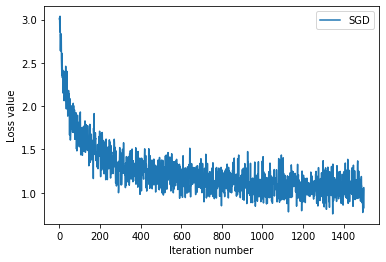

In [11]:
## SGD error plot
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()

### Train Softmax + SGD

In [12]:
from utils.classifiers.basic_classifiers import Softmax

## Softmax + SGD
classifier = Softmax()
reg = 1e-5 # regularization
lr = 1e-7 # learning rate
loss_hist_sgd = classifier.train(X=X_train, y=y_train, learning_rate=lr, reg=reg, num_iters=1500, optim='SGD', verbose=True)

# Write the BasicClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

iteration 0 / 1500: loss 4.840670
iteration 100 / 1500: loss 3.704404
iteration 200 / 1500: loss 2.969636
iteration 300 / 1500: loss 2.975154
iteration 400 / 1500: loss 3.003825
iteration 500 / 1500: loss 3.144466
iteration 600 / 1500: loss 2.793917
iteration 700 / 1500: loss 2.856812
iteration 800 / 1500: loss 3.011406
iteration 900 / 1500: loss 2.587462
iteration 1000 / 1500: loss 2.578647
iteration 1100 / 1500: loss 2.774058
iteration 1200 / 1500: loss 2.709007
iteration 1300 / 1500: loss 2.682542
iteration 1400 / 1500: loss 2.471507
training accuracy: 0.256796
validation accuracy: 0.256000


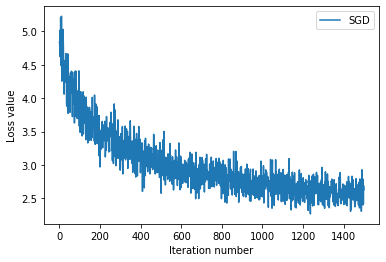

In [13]:
## SGD loss curve
plt.plot(loss_hist_sgd, label='SGD')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend()
plt.show()